In [1]:
from itertools import product, combinations
import math
import base64
import io
from pathlib import Path
from collections import Counter
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import torch
from tensorboard.backend.event_processing import event_accumulator
from plotnine import *
import Levenshtein
from sklearn.cluster import SpectralClustering, DBSCAN, AgglomerativeClustering
import numpy as np
import random
import magicsoup as ms
from experiments.e1_co2_fixing.main import CHEMISTRY

theme_set(theme_minimal())
THIS_DIR = Path(".") / "experiments" / "e1_co2_fixing"
RUN_NAME = "2023-01-16_18-27"
RUN_DIR = THIS_DIR / "runs" / RUN_NAME

In [50]:
def replicate(t: torch.Tensor, k=15.0) -> torch.Tensor:
    return t ** 5 / (t ** 5 + k ** 5)

def kill(t: torch.Tensor, k=0.5) -> torch.Tensor:
    return k ** 4 / (t ** 4 + k ** 4)

actions = {"replicated": replicate, "killed": kill}
n_mols = [1.0, 2.0, 3.0, 4.0, 5.0]
steps = list(range(1000))

records = []
for action, fun in actions.items():
    for n_mol in n_mols:
        for step in steps:
            records.append({
                "step": step,
                "n(X)": n_mol,
                "p(action)": (1 - (1 - fun(n_mol)) ** step),
                "action": action,
            })

df = pd.DataFrame.from_records(records)

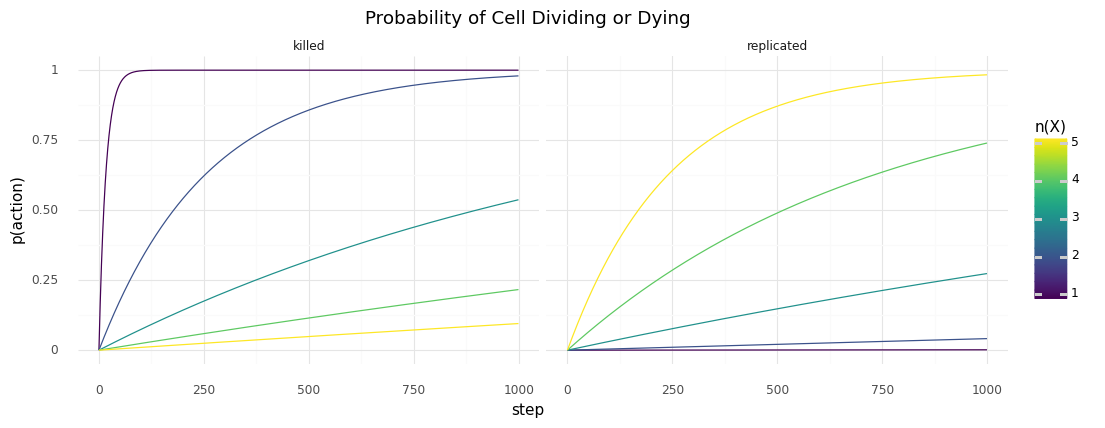

<ggplot: (8739392829410)>

In [51]:
(ggplot(df, aes(y="p(action)", x="step"))
    + geom_line(aes(color="n(X)", group="n(X)"))
    + facet_grid(". ~ action")
    + theme(figure_size=(12, 4))
    + ggtitle("Probability of Cell Dividing or Dying"))

In [14]:
cell_scalars = ["Divisions[avg]", "Survival[avg]", "total[n]"]

records = []
tf_event_file = next(RUN_DIR.glob("*.out.tfevents.*"))
tf_ea = event_accumulator.EventAccumulator(str(tf_event_file))
tf_ea.Reload()
for scalar in cell_scalars:
    for obj in tf_ea.Scalars(f"Cells/{scalar}"):
        records.append({
            "scalar": scalar,
            "value": obj.value,
            "step": obj.step
        })
df = pd.DataFrame.from_records(records)

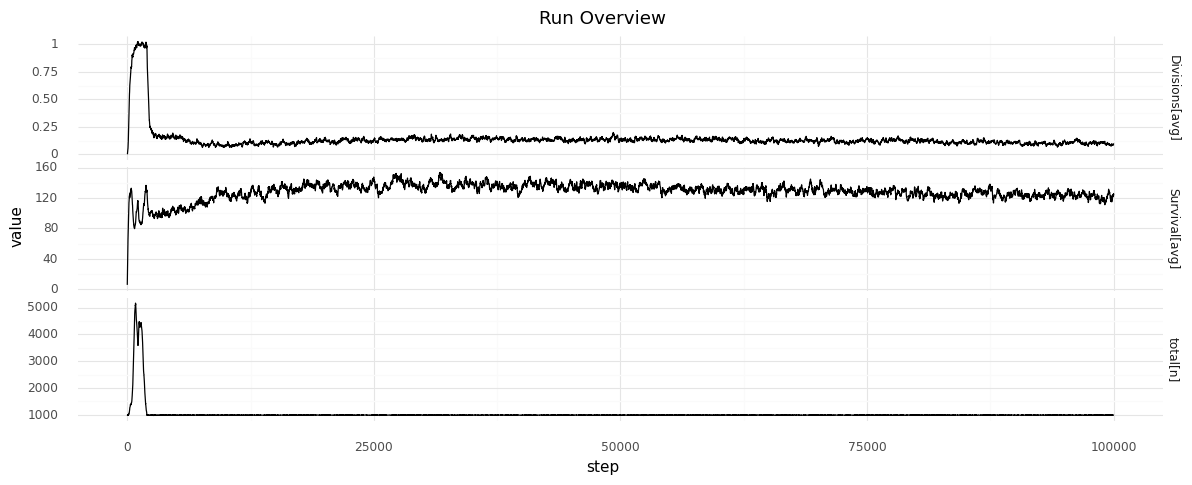

<ggplot: (8733460595234)>

In [16]:
(ggplot(df)
    + geom_line(aes(y="value", x="step"))
    + facet_grid("scalar ~ .", scales="free_y")
    + theme(figure_size=(14, 5))
    + ggtitle("Run Overview"))

In [20]:
max_idx = df.loc[df["scalar"] == "total[n]", "value"].idxmax()
max_step = df.loc[max_idx, "step"]
df.loc[max_idx]

scalar    total[n]
value       5165.0
step           843
Name: 20095, dtype: object

In [26]:
step_range = (0, 1_000)
tf_event_file = next(RUN_DIR.glob("*.out.tfevents.*"))
tf_ea = event_accumulator.EventAccumulator(str(tf_event_file), {"images": 5_000})
tf_ea.Reload()

cell_map_imgs = {}
for obj in tf_ea.Images("Maps/Cells"):
    if step_range[0] <= obj.step <= step_range[1]:
        cell_map_imgs[obj.step] = obj.encoded_image_string

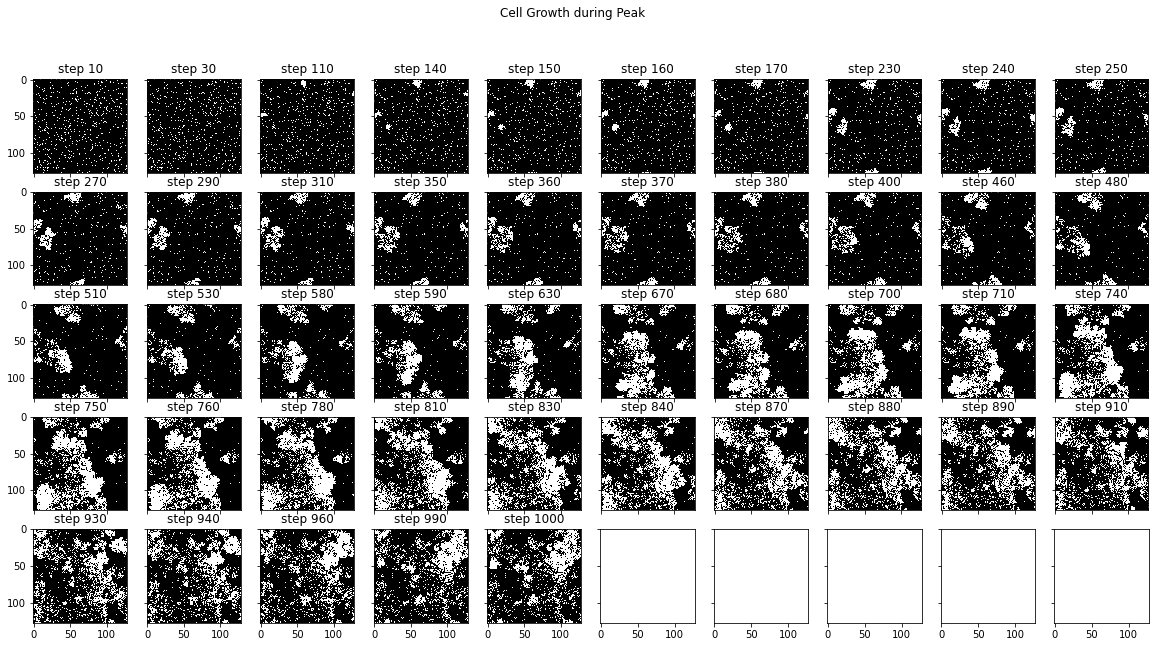

In [31]:
n_cols = 10
steps = sorted(list(cell_map_imgs))
n_rows = math.ceil(len(steps) / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(20, 2 * n_rows))
for step, ax in zip(steps, axs.flatten()):
    bimg = io.BytesIO(cell_map_imgs[step])
    img = mpimg.imread(bimg, format='JPG')
    ax.imshow(img, interpolation='nearest')
    ax.title.set_text(f"step {step}")
fig.suptitle("Cell Growth during Peak")
plt.show()

In [33]:
world = ms.World.from_file(rundir=RUN_DIR)
mol_2_idx = {d.name: i for i, d in enumerate(world.genetics.chemistry.molecules)}

all_saved_steps = sorted([int(d.name.split("step=")[1]) for d in RUN_DIR.glob("step=*")])
_, idx = min((abs(d - max_step), i) for (i, d) in enumerate(all_saved_steps))
max_saved_step = all_saved_steps[idx]
world.load_state(statedir=RUN_DIR / f"step={max_saved_step}")

In [34]:
mol_groups = {
    "carbon source": ["CO2"],
    "energy source": ["ATP/ADP", "NADPH/NADP"],
    "methyl branch": ["FH4", "formyl-FH4", "methyl-FH4", "methylen-FH4", "formiat"],
    "carbonyl branch": ["HS-CoA", "acetyl-CoA", "Ni-ACS", "methyl-Ni-ACS"],
}

records = []
for step in [d for d in all_saved_steps if step_range[0] <= d <= step_range[1]]:
    world.load_state(statedir=RUN_DIR / f"step={step}")
    for mol, idx in mol_2_idx.items():
        records.append({
            "molecule": mol,
            "n[i]": world.cell_molecules[:, idx].sum().item(),
            "n[e]": world.molecule_map[idx].sum().item(),
            "n_cells": len(world.cells),
            "step": step
        })
df = pd.DataFrame.from_records(records)

df["n"] = df["n[i]"] + df["n[e]"]
data = df.loc[:, ["molecule", "step", "n"]]
data.rename(columns={"molecule": "name"}, inplace=True)

for high, low in [("ATP", "ADP"), ("NADPH", "NADP")]:
    d = pd.merge(data[data["name"] == high], data[data["name"] == low], on="step")
    d["n"] = d["n_x"] / d["n_y"]
    d["name"] = f"{high}/{low}"
    data = pd.concat([data, d], ignore_index=True)

mol_2_grp = {dd: k for k, d in mol_groups.items() for dd in d}
data["group"] = [mol_2_grp.get(d, "other") for d in data["name"]]
data["group"] = pd.Categorical(data["group"], categories=list(mol_groups) + ["other"])
data["name"] = pd.Categorical(data["name"], categories=list(mol_2_grp))

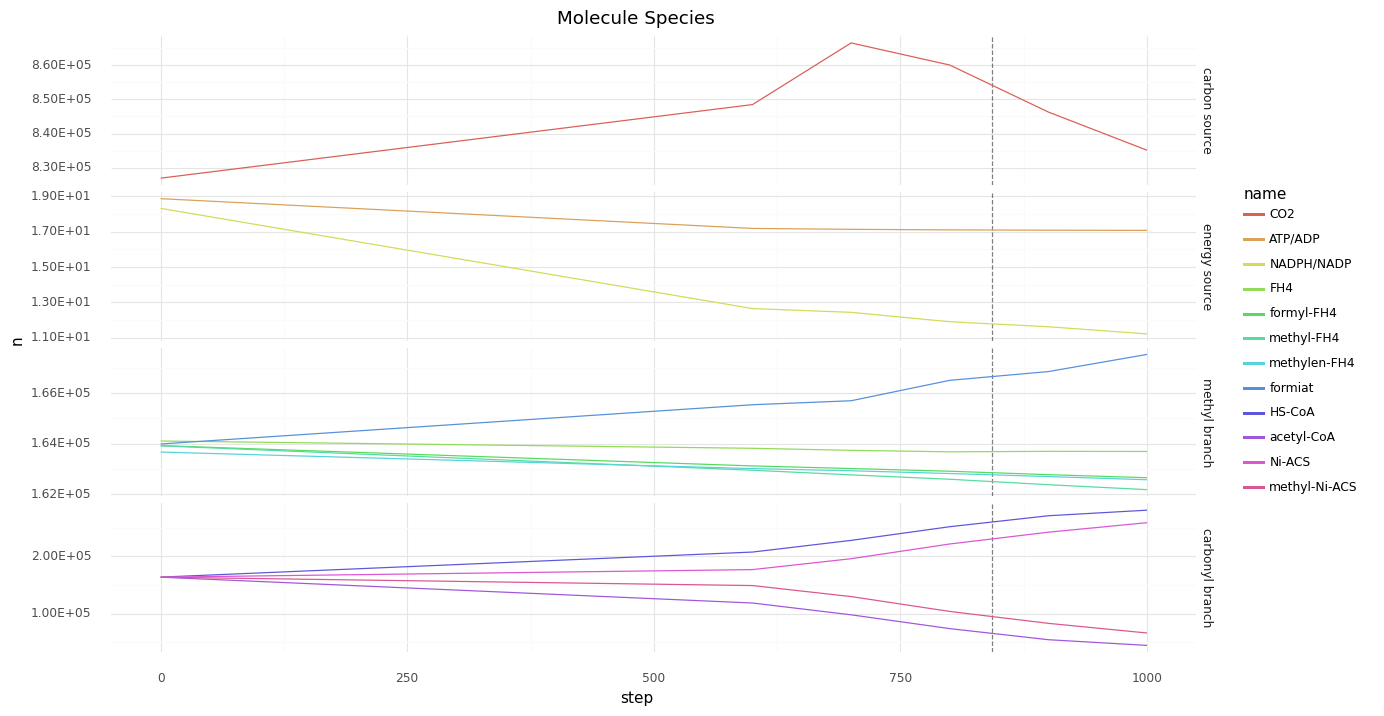

<ggplot: (8733448635386)>

In [35]:
(ggplot(data[data["name"].isin(list(mol_2_grp))])
    + geom_vline(xintercept=max_step, linetype="dashed", alpha=0.5)
    + geom_line(aes(y="n", x="step", color="name"))
    + scale_y_continuous(labels=lambda d: [f"{dd:.2E}" for dd in d])
    + facet_grid("group ~ .", scales="free_y")
    + theme(figure_size=(14, 8))
    + ggtitle("Molecule Species"))

In [45]:
picker = {
    600: [(45, 100), (55, 75)],
    700: [(45, 45)],
    800: [],
    900: [],
}

records = []
for step in picker:
    world.load_state(statedir=RUN_DIR / f"step={step}")
    for cell_i, cell in enumerate(world.cells):
        records.append({
            "step": step,
            "x": cell.position[0],
            "y": cell.position[1],
            "cell_idx": cell_i
        })
df = pd.DataFrame.from_records(records)

df["colony"] = "none"
for step, colonies in picker.items():
    step_filter = df["step"] == step
    for coli, (xm, ym) in enumerate(colonies):
        x_filter = (df["x"] >= xm - 5) & (df["x"] <= xm + 5)
        y_filter = (df["y"] >= ym - 5) & (df["y"] <= ym + 5)
        df.loc[step_filter & x_filter & y_filter, "colony"] = f"s{step}:{coli}"

colony_names = sorted(list(set(df["colony"].unique()) - {"none"}))
colors = scale_color_brewer("qual").palette(len(colony_names))
df["colony"] = pd.Categorical(df["colony"], categories=["none"] + colony_names)

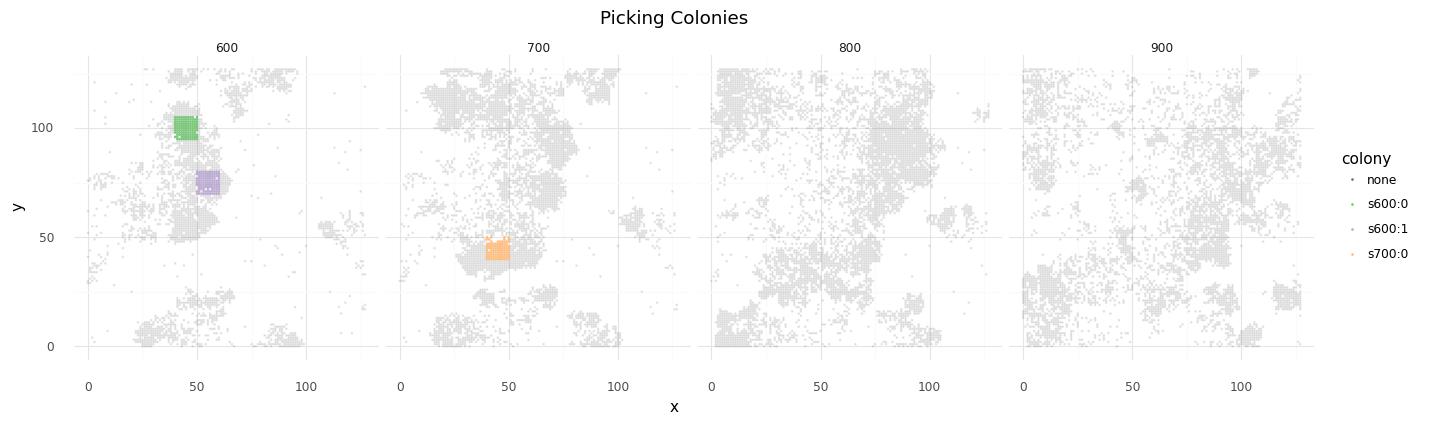

<ggplot: (8733460108322)>

In [46]:
(ggplot(df)
    + geom_point(aes(x="x", y="y", color="colony"), size=0.1)
    + scale_color_manual(values=["#7a7a7a26"] + colors)
    + coord_fixed(ratio=1)
    + facet_wrap("~ step", ncol=4)
    + theme(figure_size=(16, 5))
    + ggtitle("Picking Colonies"))

In [47]:
def distance(seq0: str, seq1: str) -> float:
    if len(seq0) == 0 or len(seq1) == 0:
        return 1.0
    return Levenshtein.distance(seq0, seq1) / max(len(seq0), len(seq1))

colonies = {}
for step in picker:
    step_filter = df["step"] == step
    world.load_state(statedir=RUN_DIR / f"step={step}")
    cell_pos_2_idx = {d.position: i for i, d in enumerate(world.cells)}
    colnames = set(df.loc[step_filter, "colony"].unique()) - {"none"}
    for colname in colnames:
        pos = df.loc[step_filter & (df["colony"] == colname), ["x", "y"]]
        cell_idxs = [cell_pos_2_idx[d] for d in pos.itertuples(index=False, name=None)]
        colonies[colname] = [world.get_cell(by_idx=d) for d in cell_idxs]

colony_prototypes = {}
for colname, colcells in colonies.items():
    n_col_cells = len(colcells)
    D = np.zeros((n_col_cells, n_col_cells))
    for i, j in combinations(range(n_col_cells), 2):
        dist = distance(colcells[i].genome, colcells[j].genome)
        D[i, j] = dist
        D[j, i] = dist
    colony_prototypes[colname] = colcells[np.argmin(D.sum(0))]

/home/marc/luca/magicsoup/world.py:142: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)


In [48]:
world.load_state(statedir=RUN_DIR / f"step={max_saved_step}")

def norm(x: pd.Series) -> pd.Series:
    mind = np.quantile(x, 0.05)
    maxd = np.quantile(x, 0.95)
    return ((x - mind) / (maxd - mind)).clip(0.0, 1.0)

records = []
for colname, prototype in colony_prototypes.items():
    for cell_idx, cell in enumerate(world.cells):
        records.append({
            "cell_idx": cell_idx,
            "x": cell.position[0],
            "y": cell.position[1],
            "colony": colname,
            "d(prototype)": distance(prototype.genome, cell.genome)
        })
df = pd.DataFrame.from_records(records)

avg_dists = df.groupby("colony")["d(prototype)"].mean().to_dict()
sorted_colonies = sorted([(d, i) for i, d in avg_dists.items()])
df["colony"] = pd.Categorical(df["colony"], categories=[i for _, i in sorted_colonies])

df["dnorm(prototype)"] = 1.0
for colname, cell_idx in colony_prototypes.items():
    col_filter = df["colony"] == colname
    df.loc[col_filter, "dnorm(prototype)"] = norm(df.loc[col_filter, "d(prototype)"])

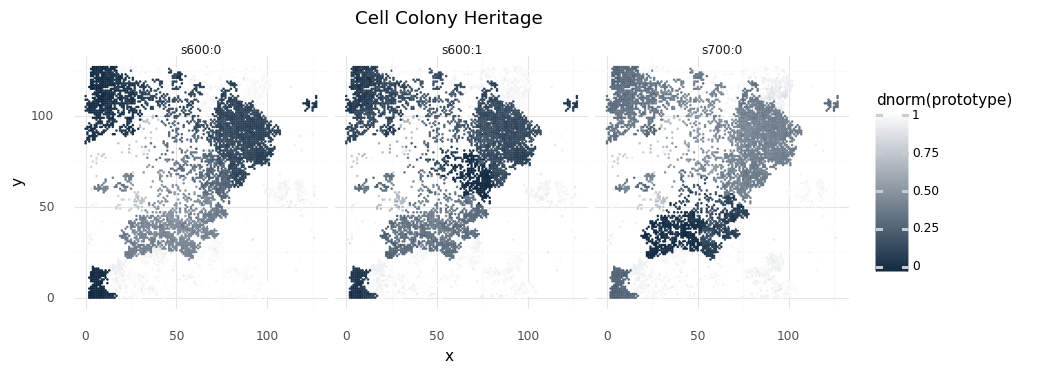

<ggplot: (8733448253690)>

In [49]:
(ggplot(df, aes(x="x", y="y"))
    + geom_point(aes(color="dnorm(prototype)"), size=0.01)
    + scale_color_gradient(low="#132B43", high="#ffffff")
    + coord_fixed(ratio=1)
    + facet_wrap("~ colony", ncol=3)
    + theme(figure_size=(10, 6))
    + ggtitle("Cell Colony Heritage"))

In [50]:
for colname, prototype in colony_prototypes.items():
    print(f"Prototype of Colony {colname}")
    domains = set()
    for protein in prototype.proteome:
        for dom in protein.domains:
            domains.add(dom)
    print(f"   {len(prototype.proteome)} proteins together with domains")
    print("  ", ", ".join(str(d) for d in domains))

Prototype of Colony s600:1
   6 proteins together with domains
   CatalyticDomain(NADPH,methylen-FH4->methyl-FH4,NADP), TransporterDomain(acetyl-CoA), TransporterDomain(methyl-Ni-ACS), CatalyticDomain(acetyl-CoA->X,HS-CoA), CatalyticDomain(HS-CoA,CO2,methyl-Ni-ACS->Ni-ACS,acetyl-CoA)
Prototype of Colony s600:0
   5 proteins together with domains
   TransporterDomain(methyl-Ni-ACS), TransporterDomain(acetyl-CoA), CatalyticDomain(acetyl-CoA->X,HS-CoA), CatalyticDomain(HS-CoA,CO2,methyl-Ni-ACS->Ni-ACS,acetyl-CoA)
Prototype of Colony s700:0
   2 proteins together with domains
   TransporterDomain(methyl-Ni-ACS), CatalyticDomain(HS-CoA,CO2,methyl-Ni-ACS->Ni-ACS,acetyl-CoA), CatalyticDomain(acetyl-CoA->X,HS-CoA)


In [64]:
show_top_p = 0.2

for colname, cells in colonies.items():
    n_cells = len(colonies[colname])
    proteins = []
    for cell in cells:
        for protein in cell.proteome:
            proteins.extend((protein.domains))

    print(f"Colony {colname}")
    counts = sorted([(d, k) for k, d in Counter(proteins).items()], reverse=True)
    for count, dom in counts:
        if count >= n_cells * show_top_p:
            print(f"  {dom}")

Colony s600:1
  CatalyticDomain(acetyl-CoA->X,HS-CoA)
  TransporterDomain(acetyl-CoA)
  CatalyticDomain(HS-CoA,CO2,methyl-Ni-ACS->Ni-ACS,acetyl-CoA)
  TransporterDomain(methyl-Ni-ACS)
Colony s600:0
  TransporterDomain(acetyl-CoA)
  TransporterDomain(methyl-Ni-ACS)
  CatalyticDomain(HS-CoA,CO2,methyl-Ni-ACS->Ni-ACS,acetyl-CoA)
  CatalyticDomain(acetyl-CoA->X,HS-CoA)
  CatalyticDomain(acetyl-CoA->X,HS-CoA)
Colony s700:0
  TransporterDomain(acetyl-CoA)
  CatalyticDomain(HS-CoA,CO2,methyl-Ni-ACS->Ni-ACS,acetyl-CoA)
  CatalyticDomain(acetyl-CoA->X,HS-CoA)


In [122]:
steps_of_interest = (max_saved_step, 25_000, 50_000)

dfs = []
for step in steps_of_interest:
    world.load_state(statedir=RUN_DIR / f"step={step}")
    dfs.append(pd.DataFrame.from_dict({
        "n_survived_steps": world.cell_survival.tolist(),
        "n_replications": world.cell_divisions.tolist(),
        "step": step
    }))
df = pd.concat(dfs, ignore_index=True)

/home/marc/anaconda3/lib/python3.9/site-packages/plotnine/stats/stat_density.py:155: PlotnineWarning: To compute the density of a group with only one value set the bandwidth manually. e.g `bw=0.1`
/home/marc/anaconda3/lib/python3.9/site-packages/plotnine/stats/stat_density.py:158: PlotnineWarning: Groups with fewer than 2 data points have been removed.
/home/marc/anaconda3/lib/python3.9/site-packages/plotnine/stats/stat_density.py:155: PlotnineWarning: To compute the density of a group with only one value set the bandwidth manually. e.g `bw=0.1`
/home/marc/anaconda3/lib/python3.9/site-packages/plotnine/stats/stat_density.py:158: PlotnineWarning: Groups with fewer than 2 data points have been removed.


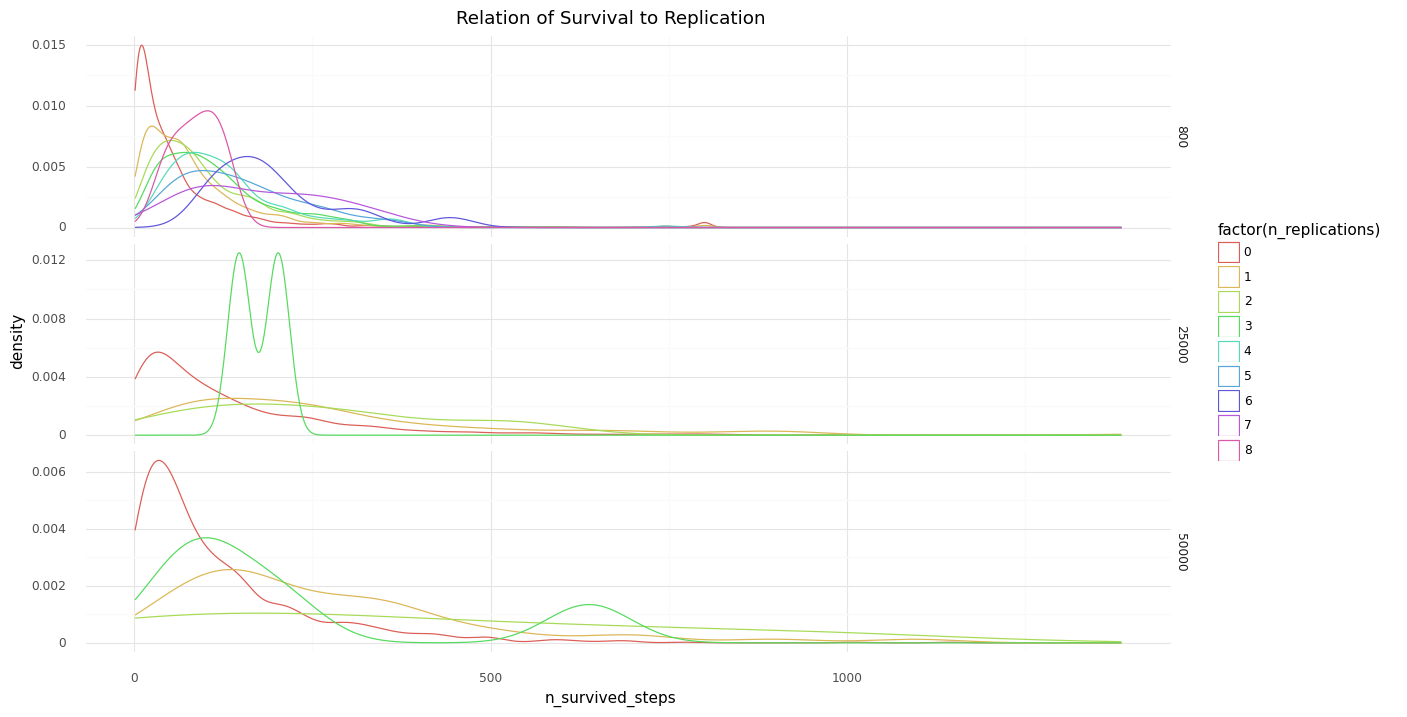

<ggplot: (8733444610094)>

In [138]:
(ggplot(df)
    + geom_density(aes(x="n_survived_steps", color="factor(n_replications)"))
    + facet_grid("step ~ .", scales="free")
    + theme(figure_size=(14, 8))
    + ggtitle("Relation of Survival to Replication"))

In [139]:
records = []
for step in steps_of_interest:
    world.load_state(statedir=RUN_DIR / f"step={step}")
    for cell_i in range(len(world.cells)):
        cell = world.get_cell(by_idx=cell_i)
        cell_kwargs = {
            "step": step,
            "n_survived_steps": cell.n_survived_steps,
            "n_replications": cell.n_replications
        }
        for protein in cell.proteome:
            for dom in protein.domains:
                if dom.is_catalytic:
                    subst = [str(d) for d in dom.substrates]
                    prods = [str(d) for d in dom.products]
                    kwargs = {"type": "catalytic", "target": f"{','.join(subst)}<->{','.join(prods)}"}
                    records.append({**cell_kwargs, **kwargs})
                if dom.is_transporter:
                    kwargs = {"type": "transporter", "target": str(dom.substrates[0])}
                    records.append({**cell_kwargs, **kwargs})
                    
df = pd.DataFrame.from_records(records)

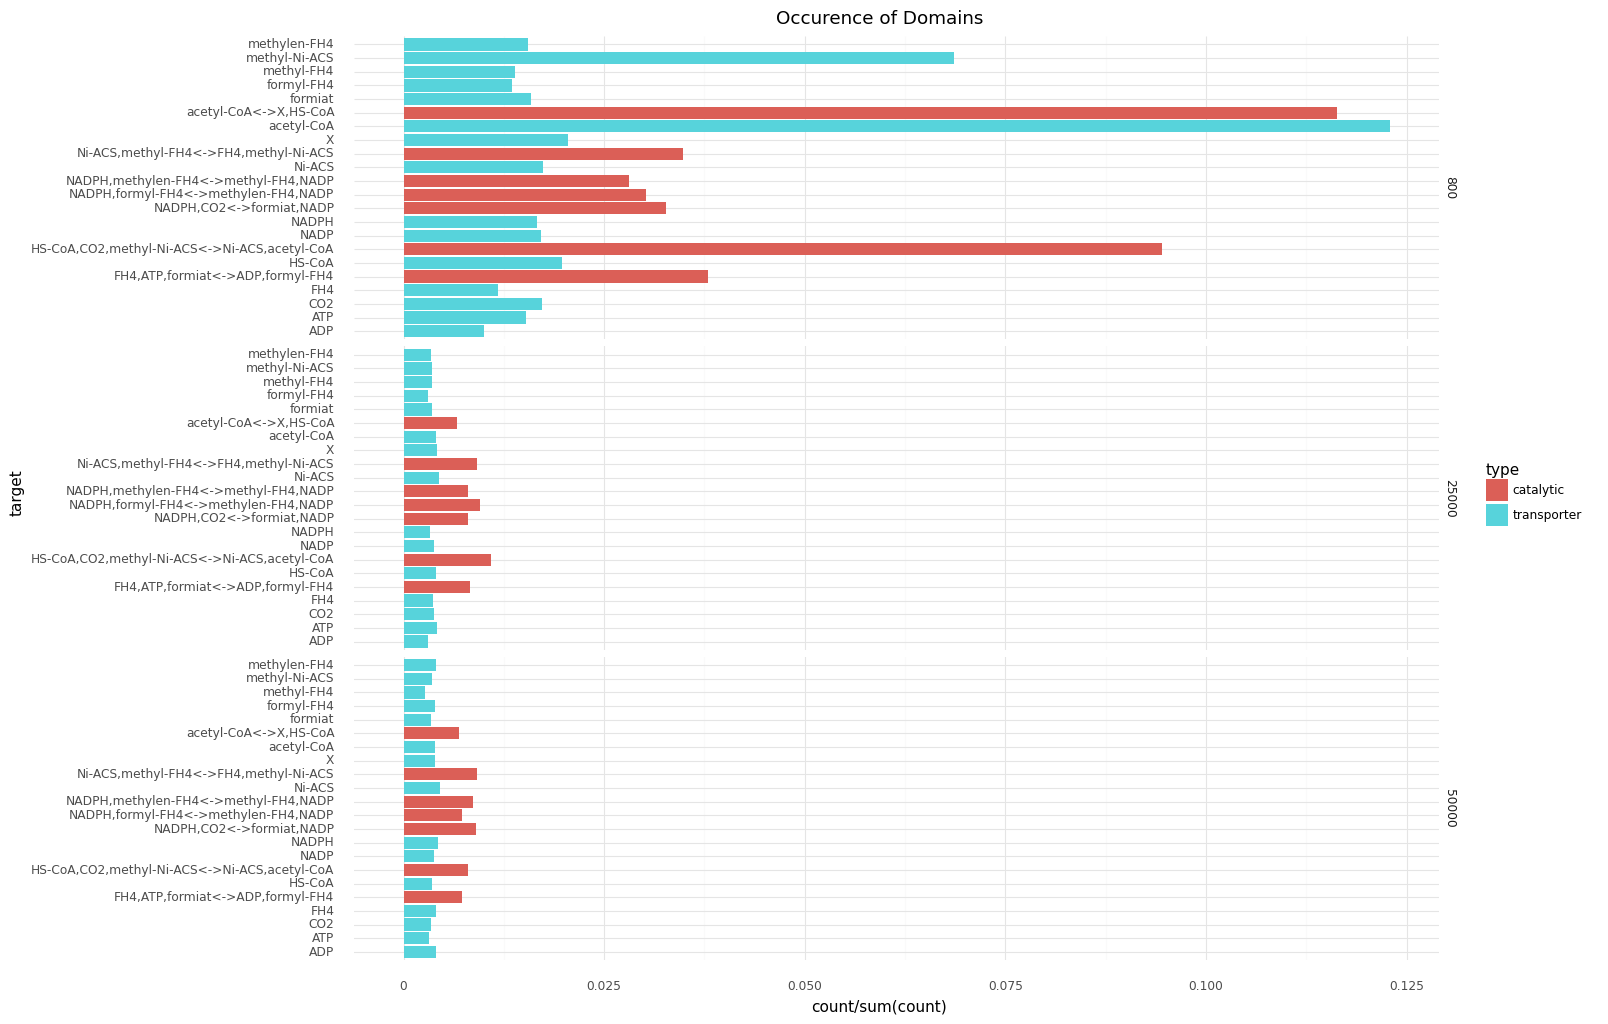

<ggplot: (8733444384500)>

In [141]:
(ggplot(df)
    + geom_bar(aes(x="target", y="..count../sum(..count..)", fill="type"))
    + facet_grid("step ~ .", scales="free")
    + coord_flip()
    + theme(figure_size=(14, 12))
    + ggtitle("Occurence of Domains"))

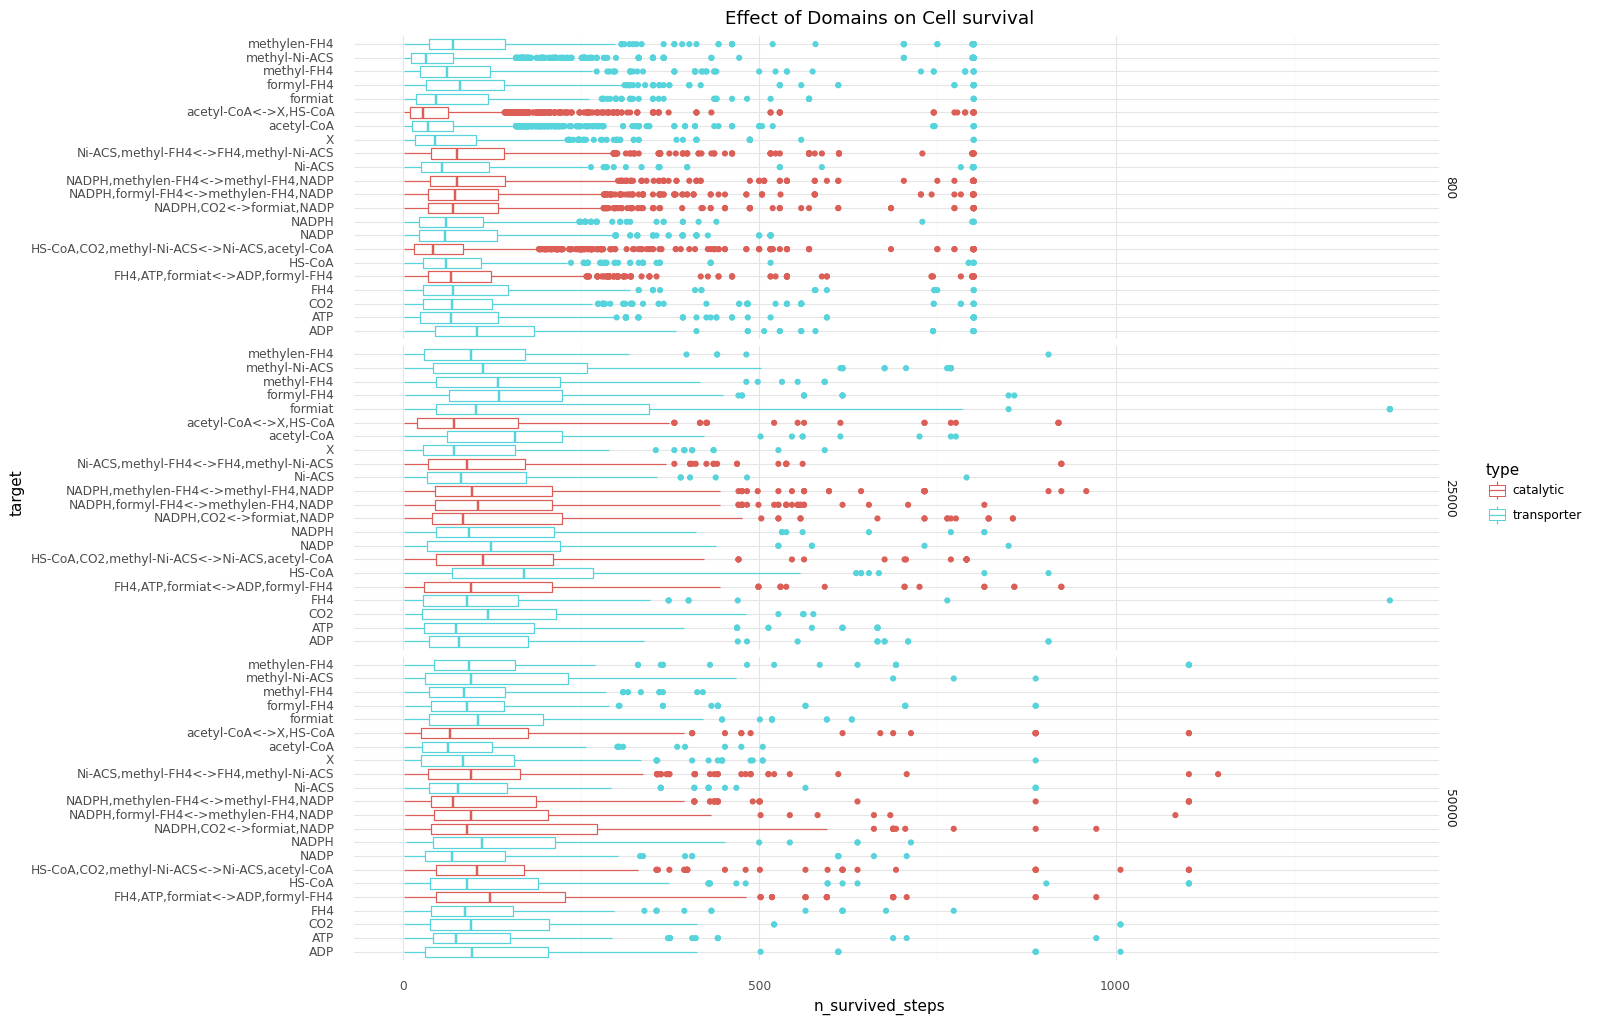

<ggplot: (8733446668472)>

In [140]:
(ggplot(df)
    + geom_boxplot(aes(x="target", y="n_survived_steps", color="type"))
    + facet_grid("step ~ .", scales="free")
    + coord_flip()
    + theme(figure_size=(14, 12))
    + ggtitle("Effect of Domains on Cell survival"))

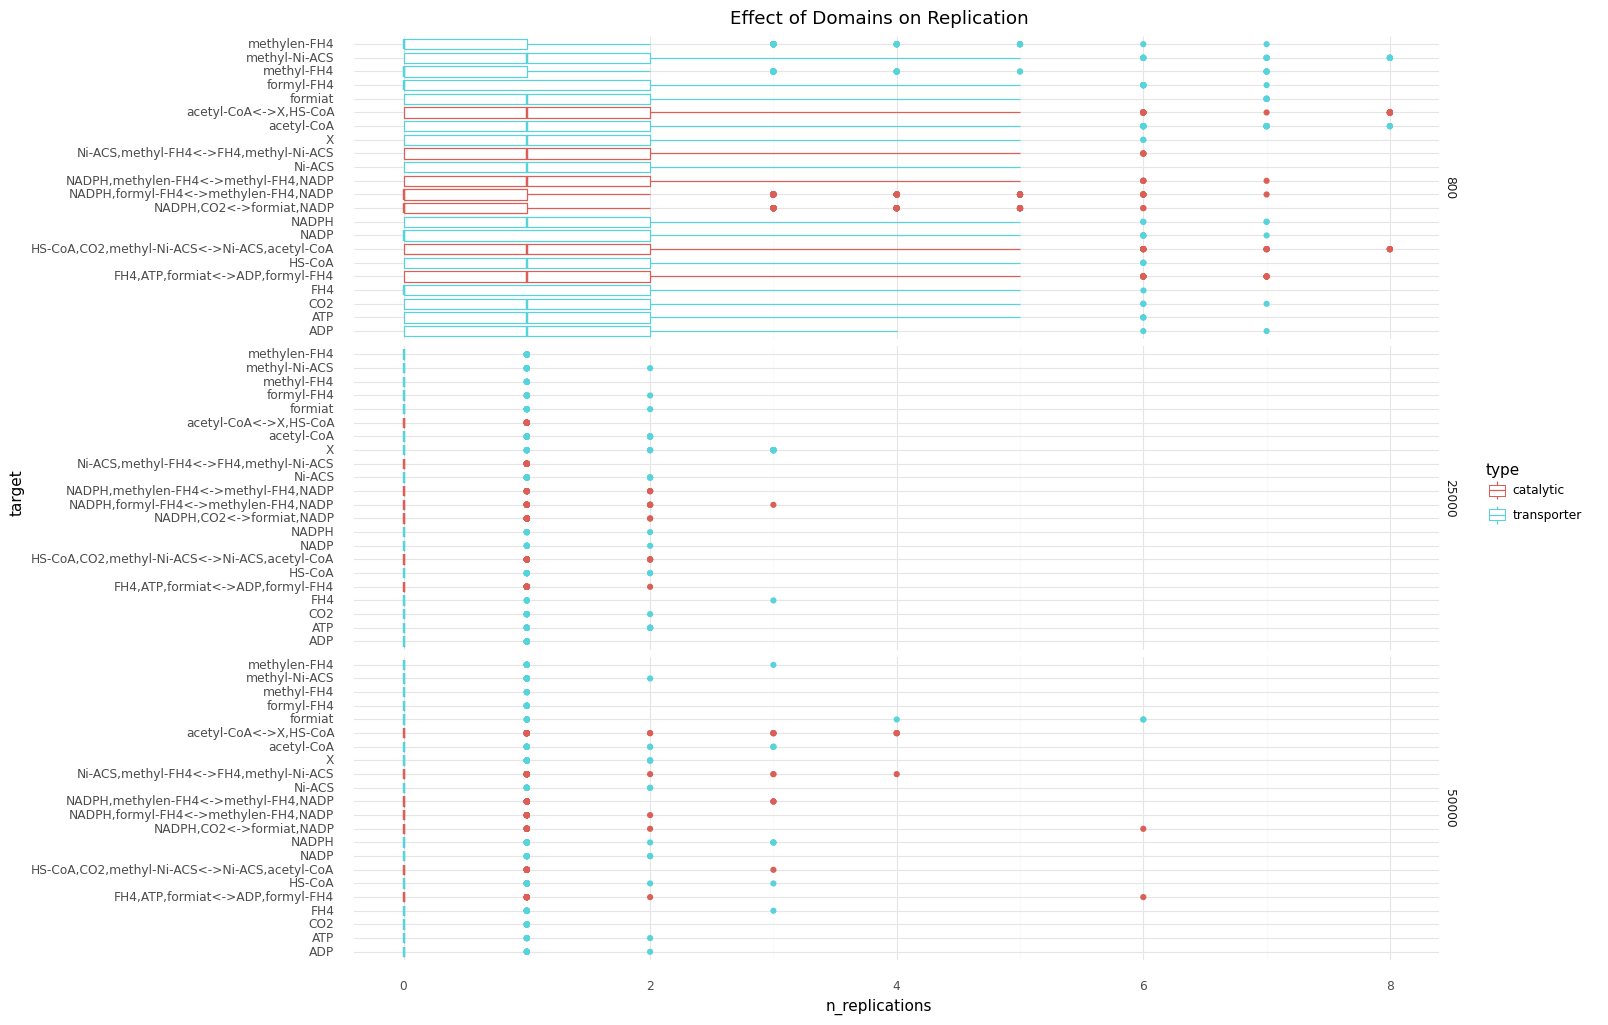

<ggplot: (8733430014377)>

In [142]:
(ggplot(df)
    + geom_boxplot(aes(x="target", y="n_replications", color="type"))
    + facet_grid("step ~ .", scales="free")
    + coord_flip()
    + theme(figure_size=(14, 12))
    + ggtitle("Effect of Domains on Replication"))